In [1]:
!pip install myqlm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.5 MB 10.8 MB/s 
     |████████████████████████████████| 495 kB 62.5 MB/s 
     |████████████████████████████████| 4.0 MB 62.6 MB/s 
     |████████████████████████████████| 90 kB 7.2 MB/s 
     |████████████████████████████████| 2.9 MB 8.1 MB/s 
     |████████████████████████████████| 252 kB 68.8 MB/s 
     |████████████████████████████████| 1.6 MB 70.2 MB/s 
     |████████████████████████████████| 45 kB 2.4 MB/s 
     |████████████████████████████████| 41 kB 607 kB/s 
     |████████████████████████████████| 17.1 MB 98 kB/s 
     |████████████████████████████████| 59 kB 5.3 MB/s 
     |████████████████████████████████| 67 kB 5.0 MB/s 
     |████████████████████████████████| 142 kB 60.0 MB/s 
     |████████████████████████████████| 49 kB 3.9 MB/s 
     |████████████████████████████████| 33.8 MB 1.3 MB/s 
  Created wheel for thrift: filename=thrift-0

## Part 1 implementing QAOA


### Question1 :
Write down in the cell below the Hamiltonian whose ground state is the solution to MaxCUT on an input graph $G=(V,E)$:

$$ H = \sum_{i,j\in E} \sigma_i \cdot \sigma_j $$

### Question 2:
Complete the implementation below of a simple, brute-force enumeration of all states computing the optimal solution to MaxCUT for the graph represented by 'edges'

In [1]:
import numpy as np

graph1 = [(0,1),(0,2),(1,3),(2,3)]
graph2 = [(0,1),(1,2),(0,3),(1,4),(2,5),(3,6),(4,7),(5,8),(3,4),(4,5),(6,7),(7,8)]
graph3 = [(0,1),(1,2),(0,3),(1,4),(2,5),(3,6),(4,7),(3,4),(4,5),(6,7)]
graph4 = [(0,1),(1,2),(2,3),(4,5),(5,6),(6,7),(0,4),(1,5),(2,6),(3,7)]
graph5 = [(0,1),(0,2),(1,3),(2,4),(3,5),(4,5),(1,4)]
graph6 = [(0,1),(0,2),(1,3),(2,4),(1,4)]


# choice of graph
edges = graph6

nqubits = max([max(list(v)) for v in edges])+1

#nqubits = 5
graph7 = [(i,(i+1)%nqubits) for i in range(nqubits)]+[(1,4)]


# COMPUTATION OF OPT.
best_value = len(edges)
best_b = 0
for x in range(2**nqubits):
    b = np.binary_repr(x, width=nqubits)
    b = [int(b[i]) for i in range(nqubits)]
    
    # TODO: Complete the computation below:

    # We want here to compute the value of <x|H|x> with H given in question 1

    val = 0

    for edge in edges:
           val += (1-2*b[edge[0]])*(1-2*b[edge[1]]) 

    # END TODO

    if val <= best_value:
        best_value = val
        best_b = b
print(best_value)
print(best_b)

-5
[1, 0, 0, 1, 1]


#### visualization of the graph

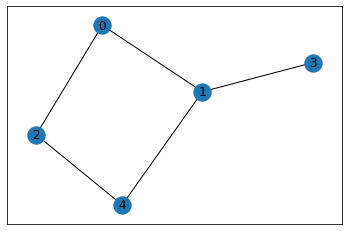

In [2]:
import networkx as nx
G = nx.Graph()
for i,j in edges:
    G.add_edge(i,j)
nx.draw_networkx(G)

In [3]:
from qat.lang.AQASM import Program, H, CNOT, RX, QRoutine, RZ, X, Z

In [4]:
def U_ZZ(theta):
    
    zz_r = QRoutine()
    zz_r.apply(CNOT, 0, 1)
    zz_r.apply(RZ(theta), 1) # difference of convention between implemented version and what we need.
    zz_r.apply(CNOT, 0, 1)

    return zz_r

### Question 3

In [5]:
def one_qaoa_layer(n_qubits, edges, theta, beta):

    layer = QRoutine()
    #TODO: implement one qaoa layer

    # We apply the Rx gate to all qubits with the same angle theta

    for i in range(n_qubits):
      layer.apply(RX(theta),i)
    
    # We then apply the unitary evolution e^(-i*beta*Hc) by applying U_ZZ on each edge

    for edge in edges:
      layer.apply(U_ZZ(beta),edge[0],edge[1])

    return layer

### Question 4

In [6]:
from qat.qpus import get_default_qpu

def evaluate_parameters(n_qubits, edges, parameters, n_layers):
    
    prog = Program()
    qubits = prog.qalloc(n_qubits)
    
    # TODO: implement initialization+parameterized circuit

    # Initialization layer
    for i in range(n_qubits):
      prog.apply(H, qubits[i])
    
    # qaoa layers
    for k in range(n_layers):
      prog.apply(one_qaoa_layer(n_qubits, edges, parameters[2*k], parameters[2*k+1]), qubits)

    # END TODO
    circ = prog.to_circ()
    
    job = circ.to_job()
    qpu = get_default_qpu()
    
    result = qpu.submit(job)
    
    # BEGIN TODO
    obs = 0
    for sample in result:
      # this loop is over all 2**nqubits states.
      # sample.state.bitstring contains the qubit values (nqubits 0 or 1)

      # We compute the mean value of the observable

      b = sample.state.bitstring
      val = 0

      for edge in edges:
        val += (1-2*int(b[edge[0]]))*(1-2*int(b[edge[1]]))

      obs+= sample.probability*val
    # END TODO
    return obs
        

In [7]:
import numpy as np
np.random.random(3)

array([0.94359358, 0.38775239, 0.17997879])

In [8]:
from scipy.optimize import minimize


### Random initialisation

### Question 5: 
réponse à la question: 10 layers to reach the optimum

0.27042907855381215 0.12196379174238733 -0.7179788514378271 -0.8861611800766928 -3.1106912043853185 -3.2767467894980666 -3.480558845369716 -3.783731235146092 -4.332776719775076 -4.541453503434067 -4.62482007599948 -4.640824883701149 -4.667431648476607 -4.699277100012674 -4.727872150383555 -4.739919407705067 -4.74984542436816 -4.751997509496147 -4.75560342625429 -4.761734809376102 -4.772408202155782 -4.791689736175627 -4.7999772429824725 -4.806549588716458 -4.809819306224032 -4.815265856906251 -4.823858766882383 -4.833283503716536 -4.841342746602169 -4.852501457724649 -4.860680658006692 -4.8642162672756335 -4.8670007660055905 -4.8685260080648565 -4.87096507420891 -4.8744228211193485 -4.876657375423887 -4.877540112193935 -4.877679964412901 -4.87783397730763 -4.877930586004103 -4.878054147113834 -4.8782739417727505 -4.878644184504393 -4.879210557983631 -4.880002457905136 -4.881290777545326 -4.883202182087006 -4.886396048080528 -4.89143975163061 -4.894284857407454 -4.897440210799575 -4.901

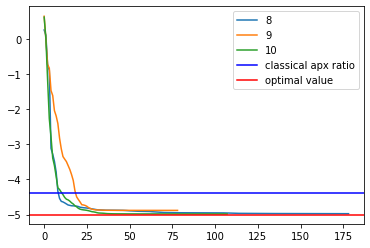

In [13]:
import matplotlib.pylab as plt


for nlayers in range(8,11,1):
    num_params = 2*nlayers

    back_trace = []
    def print_avg(xk):
        eva = evaluate_parameters(nqubits, edges, xk,nlayers)
        back_trace.append(eva)
        print(eva, end=' ')

    opt_res = minimize(lambda x : evaluate_parameters(nqubits, edges, x, nlayers), 
                       np.random.random(num_params),
                       callback=print_avg,)
    plt.plot(back_trace,label=str(nlayers))
# there exists a classical polynomial algorithm returning solutions within a factor of 0.878 of the optimal
# we must at least beat that. https://fr.wikipedia.org/wiki/Coupe_maximum
plt.axhline(0.878*best_value, color='b', label="classical apx ratio")
plt.axhline(best_value,color='r',label='optimal value')
plt.legend()

### Question 6: smart initialization

-1.559531689784106 -2.565545913889121 -3.4080524379469335 -3.868728651062756 -4.015371300312607 -4.264643007764187 -4.568491896861256 -4.678264416732678 -4.734843586042903 -4.7595565671708755 -4.803730835561107 -4.862158809281589 -4.892751015273167 -4.912306328297551 -4.919787168876411 -4.932817333322157 -4.940881386720546 -4.94416417414127 -4.947721725741926 -4.9523337037078266 -4.95487729312926 -4.956777995151656 -4.957100701494173 -4.957553163131187 -4.958078058003432 -4.958710193710118 -4.959299555844858 -4.960281175920684 -4.961713184864896 -4.962939739743431 -4.963475552557264 -4.9639315900825585 -4.964216545760238 -4.964480525639346 -4.964697248339918 -4.965032495482064 -4.965352787233723 -4.965458269098177 -4.965621262400774 -4.965789740409536 -4.96599333233748 -4.966278829893621 -4.9667372122993765 -4.96721172405436 -4.967795517498174 -4.968264728571162 -4.968510727619413 -4.968628691142449 -4.968830804646921 -4.969144811589778 -4.9694160131276846 -4.9695582866941646 -4.969757

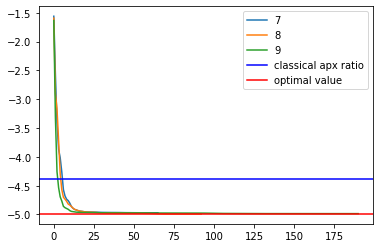

In [27]:
T = 1

for nlayers in range(7,10,1):
    num_params = 2*nlayers

    back_trace = []
    def print_avg(xk):
        eva = evaluate_parameters(nqubits, edges, xk,nlayers)
        back_trace.append(eva)
        print(eva, end=' ')

    # TODO implement parameter init

    # Theorically, we find thetak = 2T(nlayers-k)/nlayers^2 and betak = kT/nlayers^2
    parameters_init = []

    for k in range(nlayers):
      parameters_init.append(2*T*(nlayers-k)/nlayers**2)
      parameters_init.append(k*T/nlayers**2)

    # END TODO        
    opt_res = minimize(lambda x : evaluate_parameters(nqubits, edges, x, nlayers), 
                       parameters_init, 
                       callback=print_avg,)
    plt.plot(back_trace,label=str(nlayers))
plt.axhline(0.878*best_value, color='b', label="classical apx ratio")
plt.axhline(best_value,color='r',label='optimal value')
plt.legend()

We remark that the "smart initialization" with the optimal initial values of the parameters enables a convergence with less QAOA layers (the convergence is for example reached for nlayers = 7, with T = 1).